In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv     dataframe_flow_variable_1D.csv
dataframe_dma_flow_60min.csv  dataframe_flow_variable_60min.csv
dataframe_flow_1D.csv         DMA_225.csv


In [4]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_225.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')

In [5]:
data.rename( columns={'Flow':'DMA_225','Date-time':'Date_time'}, inplace=True )

In [6]:
data_DMA225 = data[['Date_time','DMA_225']]

In [7]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')

In [8]:
data_DMA225_indexed.shape

(35040, 1)

In [9]:
data_DMA225_indexed.head(5)

,DMA_225
Date_time,
2016-04-01 00:00:00,1.444
2016-04-01 00:15:00,1.444
2016-04-01 00:30:00,1.333
2016-04-01 00:45:00,1.222
2016-04-01 01:00:00,1.111


Hourly data

In [10]:
# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()

hourly_data.isnull().sum().sum()
hourly_data.isna().sum().sum()
data_hourly = hourly_data.values

# Scaling the data 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_hourly)
scaled_hourlydata = pd.DataFrame(scaled_data)

# Restructuring the data
def reshaped_hourlydata(data,step_input,step_output):
  final_data =  np.array([data[i:i + (step_input+step_output)].copy() for i in range(len(data) - (step_input+step_output))])
  return final_data

final_hourlydata = reshaped_hourlydata(scaled_hourlydata,12,24)
final_hourlydata.shape

(8724, 36, 1)

Train test split using cross validation

In [12]:
# The dataset is divided to 60% training set and the remaining 40% into validation and testing set.
train_size = int(len(final_hourlydata)*0.6)
remaining_data = len(final_hourlydata) - train_size
# With the remaining data 70% is considered for validation set and 30% for test set.
validation_data = int((remaining_data)*0.7)
testing_data = remaining_data-validation_data
valid_size = (train_size)+(validation_data)
#train_size = 6979
#rem = 1745
#valid_size = 7852
#  Restructing the dataset:
step_input = 12
step_output = 24
train_X = final_hourlydata[:train_size, :step_input]
valid_X = final_hourlydata[train_size:valid_size, :step_input]
test_X = final_hourlydata[valid_size:, :step_input]
y = np.empty((len(final_hourlydata), step_input, step_output))
for future_value in range(1, step_output + 1):
    y[..., future_value - 1] = final_hourlydata[..., future_value:future_value + step_input, 0]
train_y = y[:train_size]
valid_y = y[train_size:valid_size]
test_y = y[valid_size:]

print("The shape of train_X is:",train_X.shape)
print("The shape of valid_X is:",valid_X.shape)
print("The shape of test_X is:",test_X.shape)

The shape of train_X is: (5234, 12, 1)
The shape of valid_X is: (2443, 12, 1)
The shape of test_X is: (1047, 12, 1)


LSTM 

In [13]:
model = tf.keras.Sequential()
model.add(LSTM(40, activation = 'relu',return_sequences=True,input_shape=(None, 1)))
model.add(Dropout(0.5))
model.add(Dense(24))
opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss="mse", optimizer=opt)
history = model.fit(train_X, train_y, epochs=50,validation_data=(valid_X, valid_y))

Epoch 1/50
164/164 [==============================] - 2s 7ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 2/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 3/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 4/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 5/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 6/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 7/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 8/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 9/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0014

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 40)          6720      
_________________________________________________________________
dropout (Dropout)            (None, None, 40)          0         
_________________________________________________________________
dense (Dense)                (None, None, 24)          984       
Total params: 7,704
Trainable params: 7,704
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

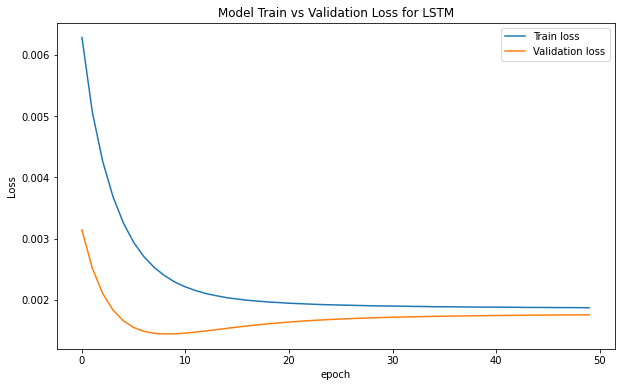

In [16]:
plot_loss(history,'LSTM')

In [17]:
#Generate predictions
train_pred = model.predict(train_X)
#evaluation = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = model.predict(test_X)
predictions = test_pred

In [18]:
# To make a dataframe of original and predicted value:
lstm_df=[]
for i in range (0, len(predictions)):
  lstm_df.append((predictions[i][0][step_output-1]))
final_df = pd.DataFrame((test_X[:,0]))
final_df.rename(columns = {0:'original_value'}, inplace = True)
final_df['predicted_value'] = lstm_df


In [19]:
final_df.head(3)

,original_value,predicted_value
0,0.029934,0.071396
1,0.031808,0.071411
2,0.024319,0.071291


In [20]:
# To calculate the percentage difference between actual and predicted value:
final_df['total_difference'] = (final_df['predicted_value'] - final_df['original_value']).abs()
final_df['percentage_difference'] = ((final_df['total_difference'])/(final_df['original_value']))*100

In [21]:
import math
from sklearn.metrics import mean_squared_error
testset = math.sqrt(mean_squared_error(final_df['original_value'], final_df['predicted_value']))
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on testset:  0.04195527571920602


In [22]:
# To make complete df:
y = [y[0] for y in test_y]
df_r = hourly_data.reset_index()
days = df_r['Date_time'].values[-len(y):]
df = pd.DataFrame(days,columns = ['Date_time'])
result = pd.concat([df, final_df], axis=1, join='inner')
result.shape

(1047, 5)

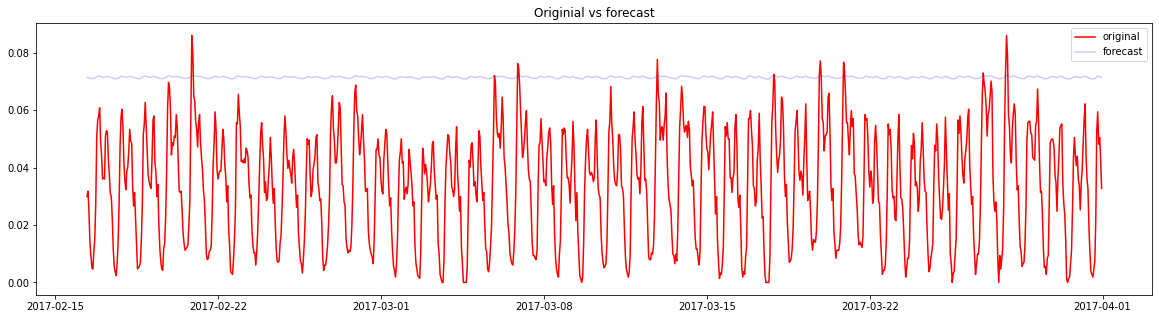

In [25]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 5))
plt.plot(result.Date_time, result.original_value, color='red', label='original')
plt.plot(result.Date_time, result.predicted_value, color='blue', label='forecast', alpha=0.2)
plt.title('Originial vs forecast')
plt.legend()
plt.show()

In [24]:
# To plot forecast graph :
forecast_df = result[['Date_time','predicted_value']]
figure = px.line(forecast_df,x="Date_time",y="predicted_value",title="DMA_225 with slider")
figure.update_xaxes(rangeselector=dict(
            buttons=list([
                dict(count=218,
                     label="218h",
                     step="hour",
                     stepmode="backward"),
                dict(count=436,
                     label="436h",
                     step="hour",
                     stepmode="backward"),
                dict(count=654,
                     label="654h",
                     step="hour",
                     stepmode="backward"),
               dict(count=872,
                     label="872h",
                     step="hour",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    )
figure.show()
